# Forward encoding model based on Pim Mostert Decoding toolbox



In [51]:
dont_edit

NameError: name 'dont_edit' is not defined

In [1]:
!pwd

/Users/junjieji/Desktop/master-thesis


In [2]:
import sys

# %matplotlib qt
from scipy.io import loadmat
import numpy as np
import pandas as pd
import mat73

import inspect #path_fun = inspect.getfile(StratifiedKFold)
import matplotlib.pyplot as plt
import DecToolbox as dt
import mne
import os
import random

from statsmodels.tsa.stattools import coint


In [3]:
path_utils = '/decoding_toolbox_py/helper_funcs' 
sys.path.append(path_utils)

Decoding modules

In [4]:
''' VARIABLES '''

#dataset = 'matlab'
dataset = 'eeg'

numC = 8
angles = [i * 180/numC for i in range(numC)]
x_labels = np.array(angles)

cfg_stim = dict()
cfg_stim['kappa'] = 4
cfg_stim['NumC'] = numC
cfg_stim['Tuning'] = 'vonmises'
# cfg_stim['Tuning'] = 'halfRectCos'
cfg_stim['offset'] = 0

cfg_train = dict()
cfg_train['gamma'] = 0.01
cfg_train['demean'] = True
cfg_train['returnPattern'] = True

cfg_test = dict()
cfg_test['demean'] = 'traindata'

Loading & preparing orientation data

In [5]:
if dataset == 'matlab':
    path = 'decoding-toolbox_matlab/data/testdata_orientation.mat' 
    ori_data = mat73.loadmat(path)
    Y = ori_data['Y']
    X = ori_data['X']
    time = ori_data['time']
    label = ori_data['label']
else:
    amount_of_subjects = 3 # Change the range so the process is faster
    if amount_of_subjects > 27: amount_of_subjects = 27
    subjs_list = ['s{:02d}'.format(i) for i in range(1, amount_of_subjects+1)] 

    path = 'Cond_CJ_EEG'
    # Read main_epo.fif files and create a list of averaged epochs
    epochs = []
    all_epochs = []
    all_rawdata = []
    all_st_epochs = []
    all_st_rawdata = []

    for subject_id in subjs_list:
        preproc_path = os.path.join(path, subject_id)
        
        epoch = mne.read_epochs(os.path.join(preproc_path, 'main_epo.fif'), verbose=False)
        epochs.append(epoch.average())

        all_epochs.append(epoch)
        all_rawdata.append({'epoch_dat': epoch.get_data(), 'metadata': epoch.metadata})

        st_epoch = mne.read_epochs(os.path.join(preproc_path, 'mainstim_epo.fif'), verbose=False)
        all_st_epochs.append(st_epoch)
        all_st_rawdata.append({'epoch_dat': st_epoch.get_data(), 'metadata': st_epoch.metadata})

    gvaverage = mne.grand_average(epochs[:])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Identifying common channels ...


In [6]:
epoch.metadata

,index,subj,nblock,ntrial,nrep,trial_type,cond-1,cond,rDV,DV,...,d5,d6,o1,o2,o3,o4,o5,o6,confi-1,conf_lvl-1
883,0,S03,0,0,0,nonrepeat,0,1,0.718127,0.20,...,0.581882,0.576271,0.138000,1.828000,0.801000,1.090000,2.192000,0.619000,0.00,L
896,1,S03,0,0,1,nonrepeat,1,1,0.718127,0.20,...,0.581882,0.576271,0.138000,1.828000,0.801000,1.090000,2.192000,0.619000,-0.25,H
909,2,S03,0,0,2,nonrepeat,1,1,0.718127,0.20,...,0.581882,0.576271,1.708796,0.257204,2.371796,2.660796,0.621204,2.189796,-0.05,H
922,3,S03,0,1,0,repeat,1,1,0.442121,0.10,...,0.311437,0.030805,0.217000,2.340000,0.420000,2.873000,0.515000,1.166000,1.00,H
935,4,S03,0,1,1,repeat,1,1,0.442121,0.10,...,0.311437,0.030805,0.217000,2.340000,0.420000,2.873000,0.515000,1.166000,0.25,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,259,S03,3,20,1,nonrepeat,0,0,0.509040,-0.11,...,0.229431,0.536046,2.332000,1.476000,3.087000,1.705000,1.088000,2.174000,-1.00,L
4266,260,S03,3,20,2,nonrepeat,0,0,0.509040,-0.11,...,0.229431,0.536046,0.761204,3.046796,1.516204,0.134204,2.658796,0.603204,-0.50,L
4279,261,S03,3,21,0,repeat,0,1,0.601341,0.21,...,-0.542671,0.324169,2.634000,0.833000,0.544000,2.759000,2.962000,0.520000,-0.65,L
4292,262,S03,3,21,1,repeat,1,1,0.601341,0.21,...,-0.542671,0.324169,2.634000,0.833000,0.544000,2.759000,2.962000,0.520000,-1.00,L


In [7]:
one = True
if one:
    ival = 0
    Y = all_st_rawdata[ival]['epoch_dat']
    Y = np.einsum('kji->jik', Y)
    Y = np.delete(Y, 25, axis=0) # Delete eye channel because signals are 1e3 higher than the other series
    X = np.array(all_st_rawdata[ival]['metadata'].orient)
    time = all_st_epochs[ival].times
    label = all_st_epochs[ival].ch_names
    X = np.digitize(X, bins = np.array(angles))-1.
else:
    ival = 0
    YY = all_st_rawdata[ival]['epoch_dat']
    YY = np.einsum('kji->jik', YY)
    XX = np.array(all_st_rawdata[ival]['metadata'].orient)
    tt = all_st_epochs[ival].times
    ll = all_st_epochs[ival].ch_names
    for ival in range(1, len(subjs_list)):
        YY2 = all_st_rawdata[ival]['epoch_dat']
        YY2 = np.einsum('kji->jik', YY2)
        XX2 = np.array(all_st_rawdata[ival]['metadata'].orient)
        tt2 = all_st_epochs[ival].times
        YY = np.concatenate((YY,YY2),axis=2)
        XX = np.concatenate((XX,XX2),axis=0)
        tt = np.concatenate((tt,tt2),axis=0)
    new_XX = np.digitize(XX, bins = np.array([  0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5 ]) )-1.
       

In [8]:
phi = X * (180./8);   # Presented orientation in degrees

binned_phi = np.digitize(phi, bins = np.array(angles) ) # bins collapsing degrees by similarity

numF, numT, numN = Y.shape


In [9]:
sel_t = np.where(time >=.2)[0][0];
#sel_t = 170
print(sel_t)

150


In [10]:
G = binned_phi.copy()
CONDS = np.unique(G);
nConds = CONDS.size
nfold = 2
FoldsIdx = dt.CreateFolds(G, Y, nfold)

dat = dict()
dat['X_train'] = G[ FoldsIdx[0]['train_index']]
dat['Y_train'] = np.squeeze(Y[:,sel_t, FoldsIdx[0]['train_index']])
dat['phi_train'] = phi[ FoldsIdx[0]['train_index']]

dat['X_test'] = G[ FoldsIdx[0]['test_index']]
dat['Y_test'] = np.squeeze(Y[:,sel_t, FoldsIdx[0]['test_index']])
dat['phi_test'] = phi[ FoldsIdx[0]['test_index']]

design, sortedesign = dt.stim_features(dat['phi_train'], cfg_stim)
decoder = dt.train_encoder(design, dat['Y_train'], cfg_train)

Xhat = dt.test_encoder( decoder, dat['Y_test'], cfg_test)

In [11]:
print(decoder['dmY'].shape)
print(decoder['W'].shape)
print(decoder['iW'].shape)
print(decoder['pattern'].shape)

(31, 1)
(8, 31)
(8, 31)
(31, 8)


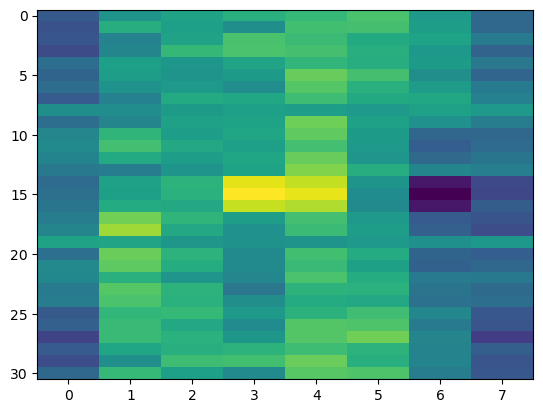

In [12]:
plt.imshow(decoder['pattern'],aspect='auto')

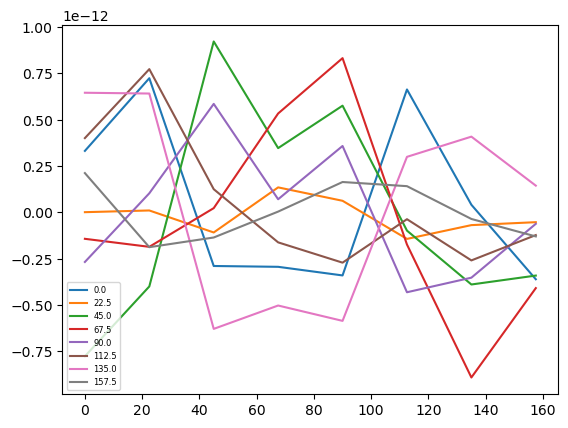

In [13]:
m = np.zeros((numC,numC))
for ic in range(numC):
    m[:,ic] =  np.mean( Xhat[:, np.where(dat['X_test'] == (ic+1))[0]], axis = 1)
plt.plot(x_labels, m)
plt.legend(x_labels, loc=3, prop={'size': 6})

__Preparing data for plotting results__

Re-alligning predictions for trials with identical orientation

In [14]:
Xhat_centered = 0*Xhat.copy()
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:,np.where(dat['X_test'] == (ic+1))] = np.roll(Xhat[:,np.where(dat['X_test'] == (ic+1))], -ic, axis = 0)

In [15]:
m_centered = np.zeros((numC,numC))
for ic in range(numC):
   m_centered[:,ic] =  np.mean( Xhat_centered[:, np.where(dat['X_test'] == (ic+1))[0]], axis = 1)

In [16]:
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

In [17]:
# Kernel to back project channel outputs to orientation space
kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
Z = kernel @ Xhat

theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

r = np.mean(np.exp(1j * (theta - dat['phi_test']) * (np.pi/180)*2)) # correlation between decoded and presented orientation
r = np.abs(r) * np.cos(np.angle(r))
r

0.03798718332292863

Getting mean orientation values for each stimulus bin

In [18]:
mtheta = np.zeros(numC)
for ic in range(numC):
    mtheta[ic] = np.mod(np.angle(np.mean(np.exp(1j * theta[np.where(dat['X_test'] == (ic+1))[0]] * (np.pi/180)*2))), 2*np.pi) * (180/np.pi) / 2

# Plotting results

[Text(0.0, 0, '0.0'),
 Text(22.5, 0, '22.5'),
 Text(45.0, 0, '45.0'),
 Text(67.5, 0, '67.5'),
 Text(90.0, 0, '90.0'),
 Text(112.5, 0, '112.5'),
 Text(135.0, 0, '135.0'),
 Text(157.5, 0, '157.5')]

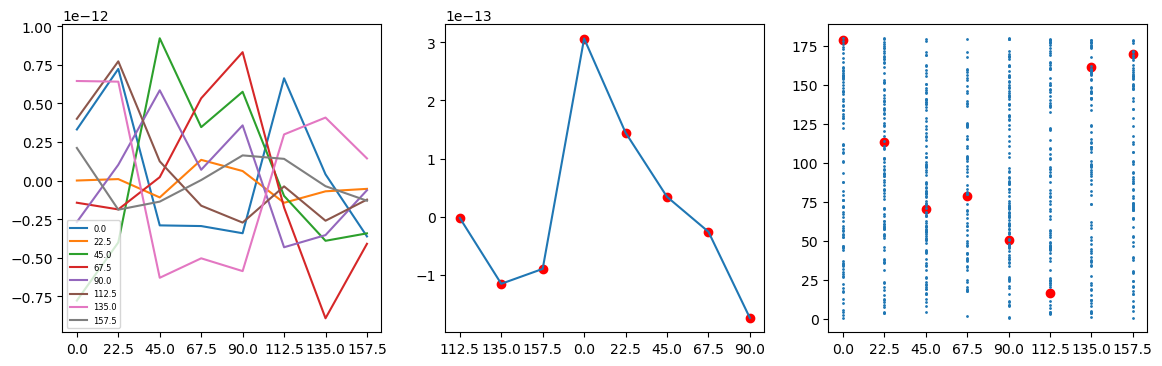

In [19]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(x_labels, m)
ax[0].set_xticks(x_labels)
ax[0].set_xticklabels(x_labels.astype(str))
ax[0].legend(x_labels, loc=3, prop={'size': 6})


ax[1].plot(x_labels, Xhat_shiftedmean)
ax[1].fill_between(x_labels, Xhat_shiftedmean-Xhat_shiftedsem, Xhat_shiftedmean+Xhat_shiftedsem)
ax[1].scatter(x_labels, Xhat_shiftedmean, color = 'red')
ax[1].set_xticks(x_labels)
ax[1].set_xticklabels(x_centeredlabels.astype(str))


ax[2].scatter(x_labels, mtheta, color = 'red')
ax[2].scatter(dat['phi_test'], theta, s = 1)
ax[2].set_xticks(x_labels)
ax[2].set_xticklabels(x_labels.astype(str))


In [20]:
# stop

np.mean(np.exp(1j * (theta - dat['phi_test']) * (np.pi/180)*2))

__Preparing crossvalidation procedure__

In [21]:
import DecToolbox as dt
from importlib import reload  # Python 3.4+
reload(dt)

<module 'DecToolbox' from '/Users/junjieji/Desktop/master-thesis/DecToolbox.py'>

In [22]:
G = binned_phi.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
CONDS = np.unique(G)
nConds = CONDS.size
nfold = 4
FoldsIdx = dt.CreateFolds(G, Y, nfold)

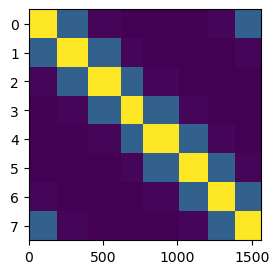

In [23]:
design, sortedesign = dt.stim_features(phi, cfg_stim)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto',interpolation = 'none')

In [24]:
from DecToolbox import CV_encoder
cfg = dict()
cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
cfg['cfgD'] = {'demean' : 'traindata'}
Xhat = CV_encoder(design, Y, sel_t, cfg, FoldsIdx)

In [25]:
m = np.zeros((numC,numC))
for ic in range(numC):
   m[:,ic] =  np.mean( Xhat[:, G == (ic+1)], axis = 1)

Re-alligning predictions for trials with identical orientation

In [26]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == (ic+1)] = np.roll(Xhat[:,G == (ic+1)], -ic, axis = 0)
    m_centered[:,ic] =  np.mean( Xhat_centered[:,  G == (ic+1)], axis = 1)

In [27]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

In [28]:
# Kernel to back project channel outputs to orientation space
kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
Z = kernel @ Xhat

theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

r = np.mean(np.exp(1j * (theta - phi) * (np.pi/180)*2)) # correlation between decoded and presented orientation
r = np.abs(r) * np.cos(np.angle(r))
r

0.024841514118796884

Getting mean orientation values for each stimulus bin

In [29]:
mtheta = np.zeros(numC)
for ic in range(numC):
    mtheta[ic] = np.mod(np.angle(np.mean(np.exp(1j * theta[G == (ic+1)] * (np.pi/180)*2))), 2*np.pi) * (180/np.pi) / 2

# Plotting results

[Text(0.0, 0, '0.0'),
 Text(22.5, 0, '22.5'),
 Text(45.0, 0, '45.0'),
 Text(67.5, 0, '67.5'),
 Text(90.0, 0, '90.0'),
 Text(112.5, 0, '112.5'),
 Text(135.0, 0, '135.0'),
 Text(157.5, 0, '157.5')]

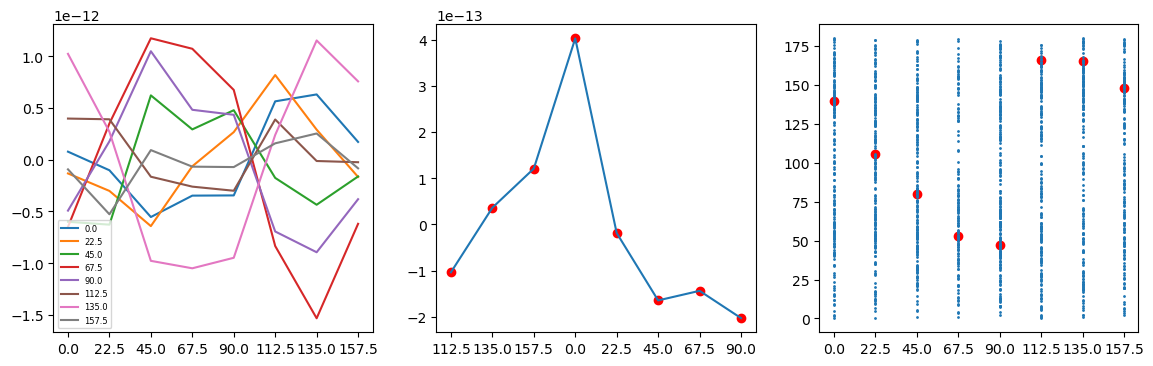

In [30]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(x_labels, m)
ax[0].set_xticks(x_labels)
ax[0].set_xticklabels(x_labels.astype(str))
ax[0].legend(x_labels, loc=3, prop={'size': 6})


ax[1].plot(x_labels, Xhat_shiftedmean)
ax[1].fill_between(x_labels, Xhat_shiftedmean-Xhat_shiftedsem, Xhat_shiftedmean+Xhat_shiftedsem)
ax[1].scatter(x_labels, Xhat_shiftedmean, color = 'red')
ax[1].set_xticks(x_labels)
ax[1].set_xticklabels(x_centeredlabels.astype(str))


ax[2].scatter(x_labels, mtheta, color = 'red')
ax[2].scatter(phi, theta, s = 1)
ax[2].set_xticks(x_labels)
ax[2].set_xticklabels(x_labels.astype(str))


# Temporal dimension decoding

In [31]:
G = binned_phi.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
CONDS = np.unique(G)
nConds = CONDS.size
nfold = 4
FoldsIdx = dt.CreateFolds(G, Y, nfold)

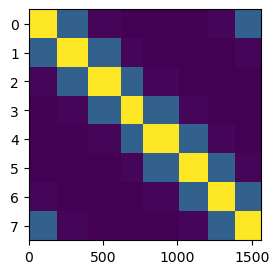

In [32]:
numC = 8 # how many channels to use
design, sortedesign = dt.stim_features(phi, cfg_stim)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto',interpolation = 'none')

In [33]:
# print(crossval)

In [34]:
numT = Y.shape[1]
Xhat = np.zeros([numC,numN, numT])
for it in range(numT):
    cfg = dict()
    cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
    cfg['cfgD'] = {'demean' : 'traindata'}
    Xhat[:,:,it] = dt.CV_encoder(design, Y, it, cfg, FoldsIdx)

In [35]:
m = np.zeros((numC,numC, numT))
for ic in range(numC):
   m[:,ic] =  np.mean( Xhat[:, G == (ic+1),:], axis = 1)

Re-alligning predictions for trials with identical orientation

In [36]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC, numT))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == (ic+1),:] = np.roll(Xhat[:,G == (ic+1),:], -ic, axis = 0)
    m_centered[:,ic, : ] =  np.mean( Xhat_centered[:,  G == (ic+1), :], axis = 1)

In [37]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

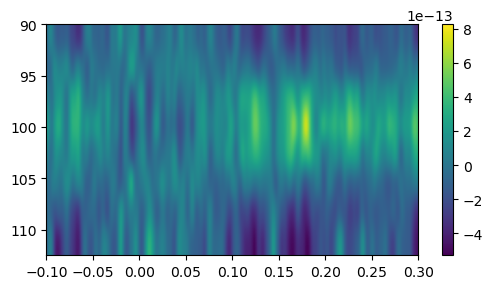

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(Xhat_shiftedmean,aspect='auto', interpolation = 'gaussian',extent=[time[0],time[-1],x_centeredlabels[0], x_centeredlabels[-1]])
plt.colorbar()

__Crossmodal temporal generalization decoding__

In [39]:
import time as tic


In [40]:
start = tic.time()
numT = Y.shape[1]
Xhat = np.zeros([numC,numN, numT, numT])
for it in range(numT):
    cfg = dict()
    cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
    cfg['cfgD'] = {'demean' : 'traindata'}
    Xhat[:,:,it, :] = dt.CV_TG_encoder(design, Y, it, cfg, FoldsIdx)
end = tic.time()

'''
macbook M1 speed
Takes 4 min for matlab dataset
takes 1 min for eeg dataset
'''

'\nmacbook M1 speed\nTakes 4 min for matlab dataset\ntakes 1 min for eeg dataset\n'

In [41]:
m = np.zeros((numC, numC, numT, numT))
for ic in range(numC):
   m[:,ic, :, :] =  np.mean( Xhat[:, G == (ic+1),:,:], axis = 1)

Re-alligning predictions for trials with identical orientation

In [42]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC, numT, numT))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == (ic+1),:, :] = np.roll(Xhat[:,G == (ic+1),:, :], -ic, axis = 0)
    m_centered[:,ic, : , : ] =  np.mean( Xhat_centered[:,  G == (ic+1), :, :], axis = 1)

'''1 min mac'''

'1 min mac'

Plotting diagonal values

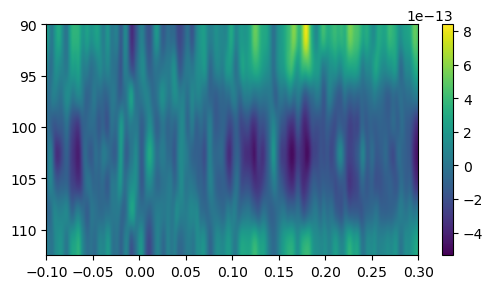

In [43]:
diagonal_vals =  m_centered[:,:,range(numT),range(numT)]
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(np.mean(diagonal_vals, axis = 1),aspect='auto', interpolation = 'gaussian',extent=[time[0],time[-1],x_centeredlabels[0], x_centeredlabels[-1]])
plt.colorbar()

Correlation between actual and predicted orientation values

In [44]:
r = np.zeros((numT, numT))

for it1 in range(numT):
    for it2 in range(numT):
        # Kernel to back project channel outputs to orientation space
        kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
        Z = kernel @ Xhat[:,:, it1, it2]

        theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

        rs = np.mean(np.exp(1j * (theta - phi) * (np.pi/180)*2)) # correlation between decoded and presented orientation
        r[it1, it2] = np.abs(rs) * np.cos(np.angle(rs))
        r
'''1 min mac'''

'1 min mac'

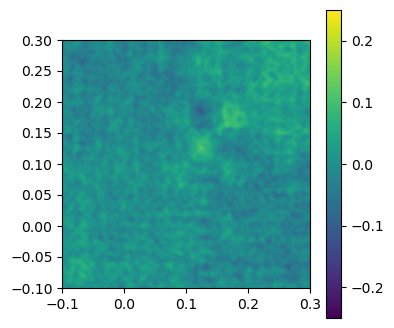

In [45]:
time_labels = [0, 0.2, 0.4, 0.6]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.imshow(r, aspect= 1, interpolation = None, vmin = -0.25, vmax = 0.25, origin = 'lower',extent=[time[0],time[-1],time[0],time[-1]])
plt.colorbar()

Getting mean orientation values for each stimulus bin

# Plotting results

In [46]:
# Creating dat containing test and train indexes
nfold = 2

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=nfold,shuffle=False)
CrossValIdx = [None] * nfold
i = 0
for train_index, test_index  in  skf.split(X = np.zeros(numN), y = X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    CrossValIdx[i] = { 'train_index': train_index, 'test_index': test_index}
    i += 1

X_train = G[ CrossValIdx[0]['train_index']][:,np.newaxis]
Y_train = np.squeeze(Y[:,sel_t, CrossValIdx[0]['train_index']]).shape
phi_train = phi[ CrossValIdx[0]['train_index']][:,np.newaxis]
X_test = G[ CrossValIdx[0]['test_index']][:,np.newaxis]
Y_test = np.squeeze(Y[:,sel_t, CrossValIdx[0]['test_index']]).shape
phi_test = phi[ CrossValIdx[0]['test_index']][:,np.newaxis]

In [47]:

X_train = G[ CrossValIdx[0]['train_index']][:,np.newaxis]
Y_train = np.squeeze(Y[:,sel_t, CrossValIdx[0]['train_index']]).shape
phi_train = phi[ CrossValIdx[0]['train_index']][:,np.newaxis]
X_test = G[ CrossValIdx[0]['test_index']][:,np.newaxis]
Y_test = np.squeeze(Y[:,sel_t, CrossValIdx[0]['test_index']]).shape
phi_test = phi[ CrossValIdx[0]['test_index']][:,np.newaxis]

In [48]:
# G[dat[0].astype(int)]

In [49]:
dat = [np.array([])]*nfold

for iCond in range(nConds):
    # Find indexes
    indx = np.where(G == CONDS[iCond])[0]
    n_indx = indx.size 
    # Shuffle indexes
    indx = np.random.permutation(indx)
    # Distribute across dat
    nelemxfold = np.floor(indx.size/nfold)
    groupNumber = np.repeat(np.arange(0,nfold), nelemxfold)

    for iFold in range(nfold):
        dat[iFold] = np.append(dat[iFold], indx[np.where(groupNumber == iFold)])
 

In [50]:
indx[np.where(groupNumber == iFold)]

array([ 522,   90, 1541,   68,  215,  480,  276,  437,  261, 1179, 1200,
        340,  430, 1426, 1413,   96,  665,  826, 1562,  800, 1015, 1080,
        346,  119,  671,  542, 1540, 1405,  677, 1009, 1206, 1003,  363,
        731, 1217,  136,   83, 1334, 1464,  431,  130,   34, 1290,  611,
        203, 1194,  442,  832,  209, 1286, 1529,  256,  876,  548,  314,
        188, 1417,   61,  533, 1407,  984,  747,  250,  592,  598,  577,
        228,  981, 1162, 1318,  466,  725, 1237, 1163, 1558,  453,  443,
        834,  817,  464, 1074, 1511, 1182,   42,  662,  617, 1429, 1296,
        183])